In [1]:
import corv
import pyphot
from pyphot import unit
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pygaia.errors.astrometric import parallax_uncertainty
import lightning as pl
import scipy.stats as ss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

Could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
model = corv.models.Spectrum('1d_da_nlte')
library = pyphot.get_library()

def forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    pc_to_m = 3.0856775814671916e16
    rsun_to_m = 6.957e8
    bands = [library[band] for band in bands]
    wavl, interp = model.wavl, model.model_spec
    flux = interp((teff, 8)) * ((radius*rsun_to_m) / (distance * pc_to_m))**2
    band_flux = np.array([band.get_flux(wavl * unit['AA'], flux * unit['erg/s/cm**2/AA'], axis=1).value for band in bands])
    return band_flux

def sim_forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    snr = np.random.uniform(300, 400)
    band_flux = forward(teff, distance, radius, bands)
    band_flux_noisy = np.random.normal(band_flux, band_flux/snr)

    gmag = -2.5 * np.log10(band_flux_noisy[0] / 2.4943e-09)
    plx_unc = parallax_uncertainty(gmag, release='dr3') * 1e-6
    plx = np.random.normal(loc = -0.000014 + (1 / distance), scale = plx_unc, size=(1))
    plx_data = np.concatenate([plx, np.array([plx_unc])])

    obs = np.concatenate([band_flux_noisy, band_flux_noisy/snr])
    return np.concatenate([plx_data, obs])

In [3]:
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
wavl = np.array([library[band].lpivot.to('AA').value for band in bands])

theta = np.array([10000, 100, 0.02])
data = sim_forward(*theta)

In [4]:
data

array([9.98020001e-03, 2.70735405e-04, 6.59001795e-17, 1.03498092e-16,
       3.61127205e-17, 1.58354813e-16, 1.27822335e-16, 6.94679428e-17,
       4.15895583e-17, 2.44328083e-17, 1.69699498e-19, 2.66517851e-19,
       9.29938371e-20, 4.07779350e-19, 3.29155190e-19, 1.78886843e-19,
       1.07097237e-19, 6.29169045e-20])

In [5]:
theta_samples = np.load('data/wdparams_theta.npy')
x_samples = np.load('data/wdparams_x.npy')

In [6]:
theta_samples[0]

array([1.13244641e+04, 3.97239183e+01, 1.51671172e-02])

In [7]:
# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

In [8]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [9]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

In [10]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """
    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
-log_prob[0]

tensor([ 4.6351,  4.7326,  4.5913,  5.2891,  5.2396,  4.8839,  5.9941,  6.2290,
         5.9840,  5.0870,  5.2300,  8.1013,  4.9158,  6.3878,  4.5945,  4.9864,
         5.6139,  5.3370,  5.1653,  4.8553,  5.7519,  5.8787,  4.5676,  5.5889,
         5.3753,  5.3822,  6.2141,  4.7245,  5.2462,  6.1130,  4.5630,  6.2278,
         4.7297,  4.8809,  7.0015,  4.6458,  4.8228,  6.9444,  5.7957,  7.0323,
         7.7972,  4.5777,  4.7942,  4.6645,  5.7125,  5.0217,  5.4203,  6.2062,
         6.8896,  5.9488,  4.5786,  5.7737,  5.3070,  5.9885,  8.2495,  5.6805,
         8.6199,  5.8109,  4.6861,  6.0961,  5.1878,  8.1075,  6.5134,  9.0991,
         7.4789,  6.0572,  5.4011,  4.6065,  4.5704, 12.2386,  6.1781,  6.0795,
         5.4449,  5.5697,  4.8183,  4.9732,  7.4566,  7.4999,  4.9521,  6.1581,
         6.0958,  8.0435,  5.5394,  4.7821,  6.5899,  6.4312,  5.8652,  5.7120,
         5.2912,  5.6062,  6.4707,  5.3686,  4.5766,  4.8053,  5.3931,  6.0300,
         5.9549,  5.1640,  5.4859,  6.66

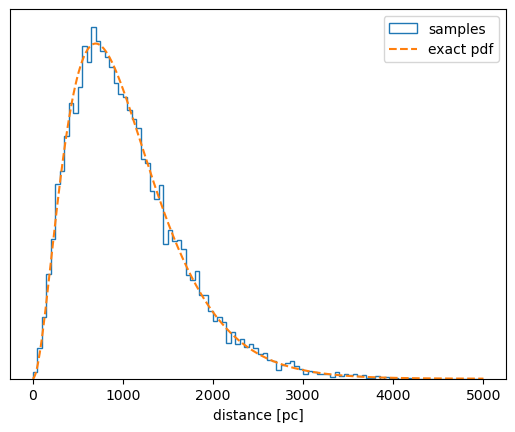

In [11]:
from torch.distributions import Chi2, transforms, transformed_distribution

L = 350
prior = transformed_distribution.TransformedDistribution(
        Chi2(6), transforms.AffineTransform(loc=0, scale=0.5 * L)
    )
r = prior.sample((10_000,))


x = np.linspace(0, 5000, 500)
plt.hist(r, 100, range=(0, 5000), density=True, histtype="step", label="samples")
plt.plot(x, 0.5 * x**2 * np.exp(-x / L) / L**3, "--", label="exact pdf")
plt.xlabel("distance [pc]")
plt.yticks([])
plt.legend();

In [12]:
def prior(theta, plx, e_plx, device, L = 350):
    # distance prior
    real_theta = theta * theta_std.to(device=device) + theta_mean.to(device=device)
    plx = plx * x_std[0].to(device=device) + x_mean[0].to(device=device)
    e_plx = e_plx * x_std[1].to(device=device) + x_mean[1].to(device=device)
    likelihood = torch.distributions.Normal(1/real_theta[:,1], e_plx).log_prob(plx)
    distance_prior = transformed_distribution.TransformedDistribution(
        Chi2(torch.tensor([6]).to(device=device)), 
        transforms.AffineTransform(loc=torch.tensor([0]).to(device=device), scale=torch.tensor([0.5 * L]).to(device=device))
    ).log_prob(real_theta[:,1])
    #uniform prior
    log_prior = torch.zeros(real_theta.shape[0], device=device)
    bounds = torch.tensor([[1000, 120000], [0, 2000], [0.001, 0.05]], device=device)
    for i in range(3):
        min_bound, max_bound = bounds[i]
        # Check if parameter i is within bounds for all examples
        within_bounds = (real_theta[:, i] >= min_bound) & (real_theta[:, i] <= max_bound)
        log_prior[~within_bounds] = np.inf
    return likelihood + distance_prior + log_prior 

In [15]:
from torch.distributions import Chi2, transformed_distribution

class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=8):
        super().__init__()
        self.d_in = 3
        self.featurizer = featurizer
        self.flow = get_flow(d_in=self.d_in, d_hidden=32, d_context=d_context, n_layers=4)
        self.prior = prior

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):     
        plx, e_plx, distance = x[:,0], x[:,1],  theta[:,1]
        prior = self.prior(theta, plx, e_plx, self.device)
        context = self(x[:,2:])
        return - self.flow.log_prob(inputs=theta, context=context) - prior

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)
    

In [16]:
npe = NeuralPosteriorEstimator(build_mlp(input_dim=x_samples.shape[1]-2, hidden_dim=16, output_dim=8, layers=2), d_context=8)
(npe.loss(x_samples[:64], theta_samples[:64]) / x_samples.shape[1]).sum()

tensor(34.7325, grad_fn=<SumBackward0>)

In [17]:
print(f"npe.device: {npe.device}")
trainer = pl.Trainer(max_epochs=40, enable_checkpointing=False)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

npe.device: cpu


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 952    | train
1 | flow       | Flow       | 21.7 K | train
--------------------------------------------------
22.6 K    Trainable params
0         Non-trainable params
22.6 K    Total params
0.090     Total estimated model params size (MB)
87        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, v_num=117, train_loss=2.900, val_loss=2.880]      

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s, v_num=117, train_loss=2.900, val_loss=2.880]


In [27]:
import corner

theta_test = np.array([7000, 200, 0.01])
x_test = sim_forward(*theta_test, bands)
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

context = npe.featurizer(x_test_norm[2:]).unsqueeze(0)
samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean

True parameters:
temperature = 7000.0 K 
distance = 200.0 pc 
radius = 1.0975 r_earth


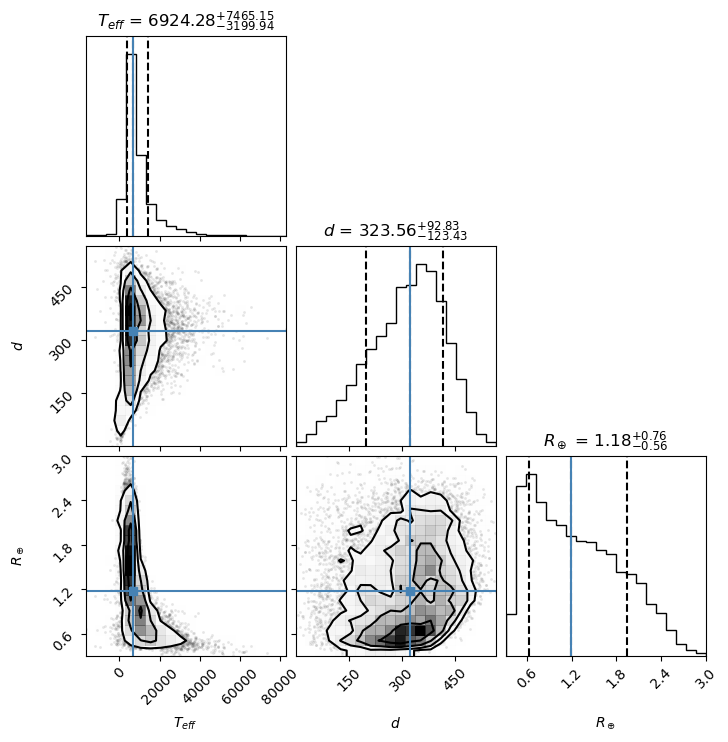

In [28]:
labels = [r"$T_{eff}$", r"$d$", r"$R_\oplus$"]
best_est = np.zeros((len(labels)))
unc = []

temp_chain = samples_test[0].detach().numpy()
temp_chain[:, 2] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

corner.corner(temp_chain, labels=labels, truths=best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.2f', title_kwargs={"fontsize": 12});
print(f"True parameters:\ntemperature = {theta_test[0]} K \ndistance = {theta_test[1]} pc \nradius = {theta_test[2]*109.75} r_earth")
plt.show()

## Test With Real Data

In [303]:
import pyvo

In [ ]:
def get_ngf21():
    tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    QUERY = f"""select top 1000 *
            from \"J/MNRAS/508/3877/maincat\" as ngf
            join \"J/A+A/674/A33/gspc-wd\" as gspc 
            on ngf.GaiaEDR3 = gspc.GaiaDR3
            where ngf.e_TeffH is not NULL and ngf.e_loggH is not NULL and ngf.e_TeffHe is not NULL and ngf.e_loggHe is not NULL
            and RAND() < 0.01"""
    return tap_service.search(QUERY).to_table().to_pandas()

ngf21 = get_ngf21()